>>> 1. 读取数据...
数据加载成功: (46564, 168)
当前列名预览: ['txId', 'label', 'split', 'feat_0', 'feat_1']

>>> 2. 执行数据切分 (根据 split 列)...
准备剔除的非特征列: ['txId', 'label', 'split']
训练集: (29894, 165), 非法比例: 11.58%
测试集: (16670, 165), 非法比例: 6.50%

>>> 3. 特征标准化 (StandardScaler)...
✅ 预处理完成，可以开始训练模型了！

>>> [Model 1] 训练 Logistic Regression (L2)...

==================== Logistic Regression (L2) 评估结果 ====================
🔴 Illicit F1-Score: 0.3031
🔴 Recall (抓全率):   0.8772
🔴 Precision (准确率): 0.1832


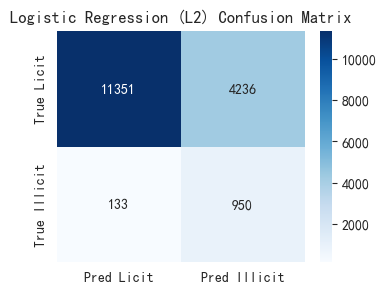


>>> [Model 2] 训练 Lasso Regression (L1)...

==================== Lasso Regression (L1) 评估结果 ====================
🔴 Illicit F1-Score: 0.3348
🔴 Recall (抓全率):   0.8301
🔴 Precision (准确率): 0.2097


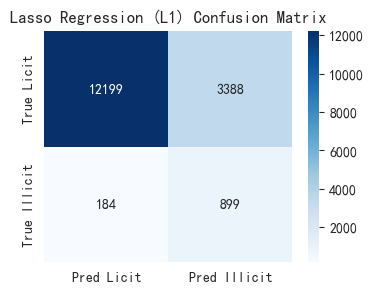

Lasso 将 66/165 个特征的系数压缩为 0 (特征筛选)


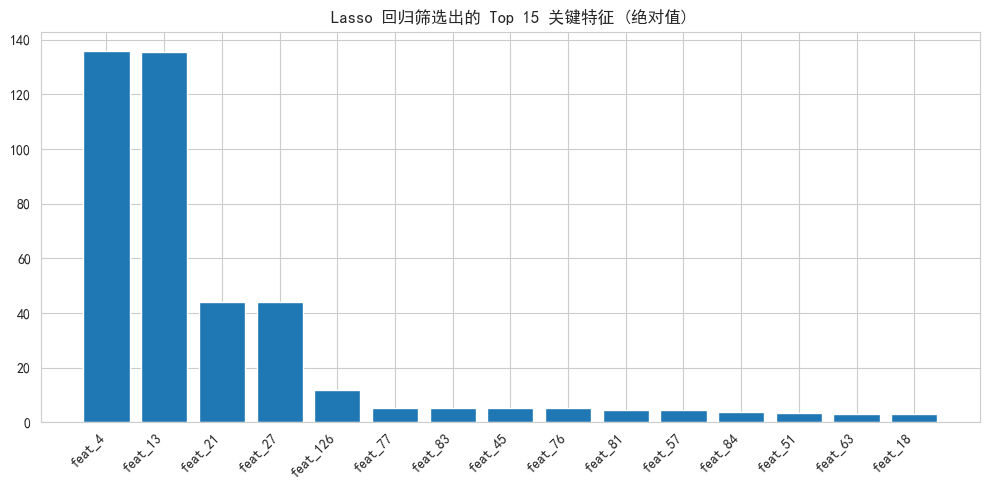


>>> [Model 3] 训练 Decision Tree...

==================== Decision Tree (Depth=5) 评估结果 ====================
🔴 Illicit F1-Score: 0.5479
🔴 Recall (抓全率):   0.7442
🔴 Precision (准确率): 0.4336


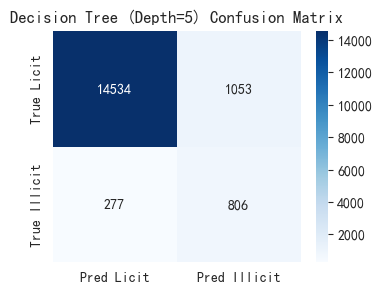

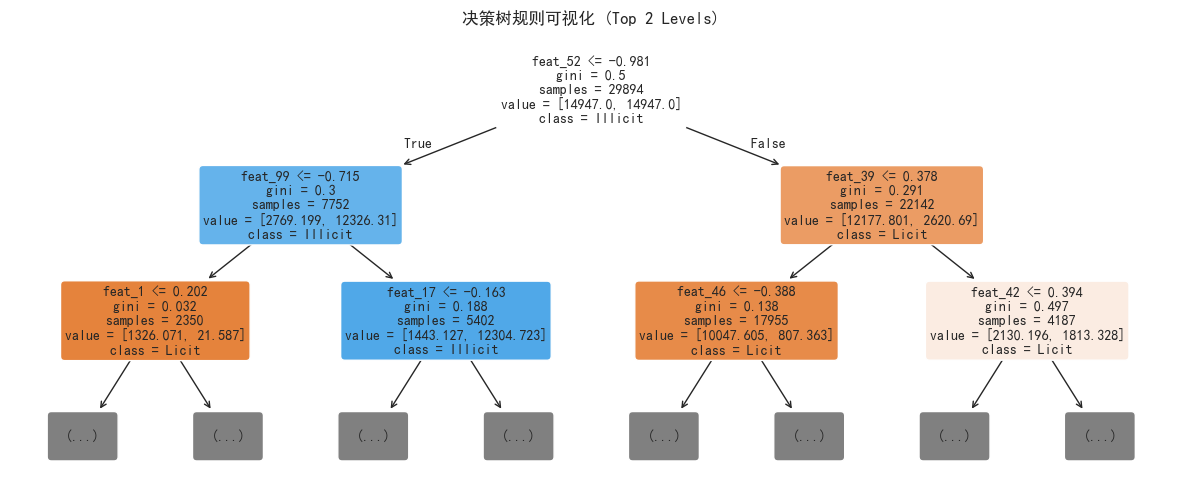


>>> 最终模型对比表 <<<
                          F1-Score    Recall  Precision   ROC-AUC
Model                                                            
Logistic Regression (L2)  0.303079  0.877193   0.183185  0.881663
Lasso Regression (L1)     0.334823  0.830102   0.209704  0.897049
Decision Tree (Depth=5)   0.547927  0.744229   0.433566  0.887981


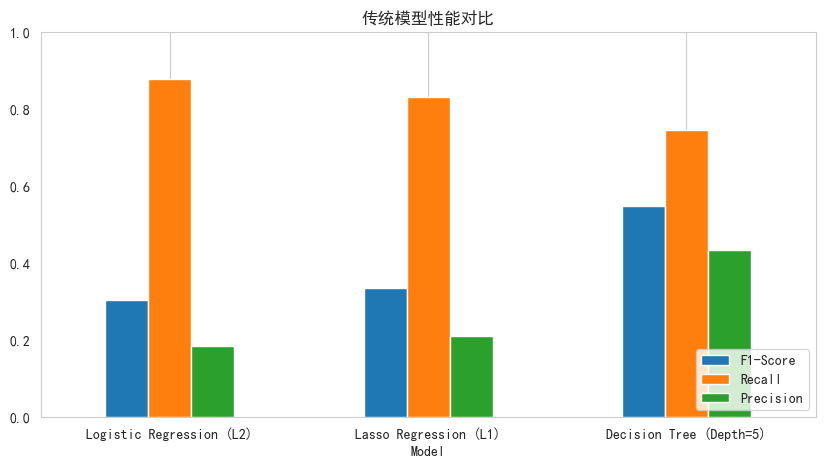

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score, confusion_matrix, roc_auc_score, precision_score, recall_score

# 设置绘图风格
sns.set_style("whitegrid")
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False

# ==========================================
# 1. 数据加载与预处理 (修复版)
# ==========================================
print(">>> 1. 读取数据...")
# 读取之前保存的基准数据
df = pd.read_csv('../data/processed/elliptic_benchmark.csv')

print(f"数据加载成功: {df.shape}")
print("当前列名预览:", df.columns.tolist()[:5])

# --- 1.1 数据切分 ---
print("\n>>> 2. 执行数据切分 (根据 split 列)...")

# 这里的 split 列是在 02 步就已经生成好的
train_df = df[df['split'] == 'train']
test_df = df[df['split'] == 'test']

# 准备特征和标签
# 定义我们要从特征矩阵中剔除的列
# 注意：这里我们使用 errors='ignore'，这样即使 Time step 不在表里也不会报错
cols_to_drop = ['txId', 'label', 'split', 'Time step', 'time_step']

# 这里的逻辑是：只删除那些“确实存在于 df 中”的列
existing_drop_cols = [c for c in cols_to_drop if c in df.columns]
print(f"准备剔除的非特征列: {existing_drop_cols}")

X_train_raw = train_df.drop(columns=existing_drop_cols)
y_train = train_df['label']

X_test_raw = test_df.drop(columns=existing_drop_cols)
y_test = test_df['label']

print(f"训练集: {X_train_raw.shape}, 非法比例: {y_train.mean():.2%}")
print(f"测试集: {X_test_raw.shape}, 非法比例: {y_test.mean():.2%}")

# --- 1.2 特征标准化 (StandardScaler) ---
print("\n>>> 3. 特征标准化 (StandardScaler)...")
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

# 保留特征名称方便后续绘图
feature_names = X_train_raw.columns
print("✅ 预处理完成，可以开始训练模型了！")

# ==========================================
# 2. 定义通用评估函数
# ==========================================
results_list = [] # 用于存储最终对比结果

def evaluate_model(model, name, X_test, y_test):
    print(f"\n{'='*20} {name} 评估结果 {'='*20}")

    # 预测
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # 核心指标
    f1 = f1_score(y_test, y_pred, pos_label=1)
    rec = recall_score(y_test, y_pred, pos_label=1)
    prec = precision_score(y_test, y_pred, pos_label=1)

    print(f"🔴 Illicit F1-Score: {f1:.4f}")
    print(f"🔴 Recall (抓全率):   {rec:.4f}")
    print(f"🔴 Precision (准确率): {prec:.4f}")

    # 存储结果
    results_list.append({
        'Model': name,
        'F1-Score': f1,
        'Recall': rec,
        'Precision': prec,
        'ROC-AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else 0
    })

    # 混淆矩阵
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred Licit', 'Pred Illicit'],
                yticklabels=['True Licit', 'True Illicit'])
    plt.title(f"{name} Confusion Matrix")
    plt.show()

# ==========================================
# 3. 模型 A: Logistic Regression (Ridge/L2)
# ==========================================
print("\n>>> [Model 1] 训练 Logistic Regression (L2)...")
# class_weight='balanced' 自动调节权重处理不平衡
lr = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
lr.fit(X_train, y_train)

evaluate_model(lr, "Logistic Regression (L2)", X_test, y_test)

# ==========================================
# 4. 模型 B: Lasso Regression (L1) - 特征筛选
# ==========================================
print("\n>>> [Model 2] 训练 Lasso Regression (L1)...")
# solver='liblinear' 支持 L1 正则化
lasso = LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', C=0.5, random_state=42)
lasso.fit(X_train, y_train)

evaluate_model(lasso, "Lasso Regression (L1)", X_test, y_test)

# --- Lasso 特有可视化: 查看系数稀疏性 ---
coefs = lasso.coef_.flatten()
zero_count = np.sum(coefs == 0)
print(f"Lasso 将 {zero_count}/{len(coefs)} 个特征的系数压缩为 0 (特征筛选)")

# 画出 Top 15 最重要的特征
indices = np.argsort(np.abs(coefs))[::-1][:15]
plt.figure(figsize=(10, 5))
plt.title("Lasso 回归筛选出的 Top 15 关键特征 (绝对值)")
plt.bar(range(15), np.abs(coefs[indices]), align='center')
plt.xticks(range(15), feature_names[indices], rotation=45, ha='right')
plt.tight_layout()
plt.show()

# ==========================================
# 5. 模型 C: Decision Tree (决策树)
# ==========================================
print("\n>>> [Model 3] 训练 Decision Tree...")
# max_depth=5 防止过拟合，保持可解释性
dt = DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=42)
dt.fit(X_train, y_train)

evaluate_model(dt, "Decision Tree (Depth=5)", X_test, y_test)

# --- 决策树特有可视化: 规则展示 ---
plt.figure(figsize=(15, 6))
plot_tree(dt, feature_names=feature_names, class_names=['Licit', 'Illicit'],
          filled=True, rounded=True, max_depth=2, fontsize=10) # 只画前2层
plt.title("决策树规则可视化 (Top 2 Levels)")
plt.show()

# ==========================================
# 6. 最终总结
# ==========================================
print("\n>>> 最终模型对比表 <<<")
summary_df = pd.DataFrame(results_list).set_index('Model')
print(summary_df)

# 可视化对比
summary_df[['F1-Score', 'Recall', 'Precision']].plot(kind='bar', figsize=(10, 5))
plt.title("传统模型性能对比")
plt.xticks(rotation=0)
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.grid(axis='y')
plt.show()